In [1]:
from dataset import Dataset
from scipy import stats
import numpy as np
import pandas as pd
import vectorbt as vbt
from analyse_candle import create_target_names
import warnings
warnings.simplefilter(action='ignore')


In [3]:
data_binance = Dataset().get_data(days=30, ticker='BTCUSDT', ts='5m')

In [4]:
data = data_binance.copy()
data['chg'] = data['close'].pct_change()
target_names = create_target_names(data)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='chg', ylabel='expected_chg_1'>

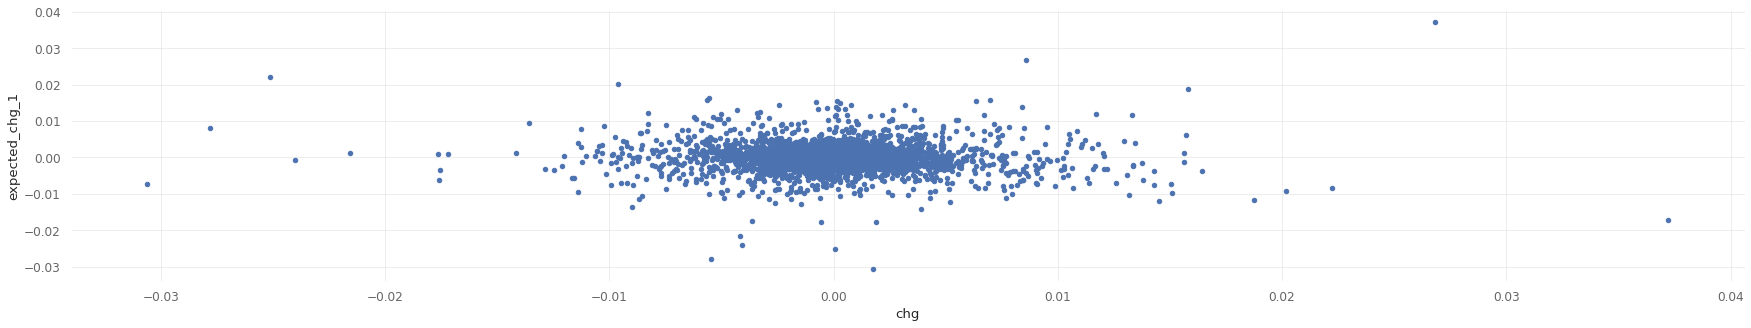

In [5]:
data[['chg', 'expected_chg_1']].plot.scatter(
    x='chg', y='expected_chg_1', figsize=(30, 5)
)

## Test ideas between two range

<AxesSubplot:xlabel='time'>

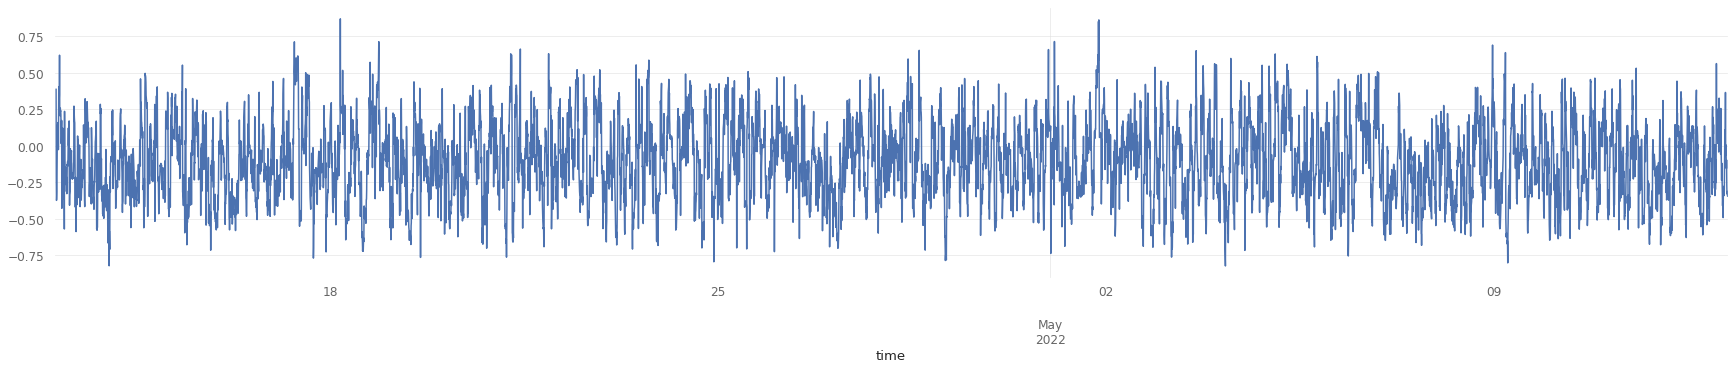

In [6]:
data['corr'] = data['chg'].rolling(12).corr(data['chg'].shift(1))
data['cuts_corr'] = pd.cut(data['corr'], bins=12, labels=False)
data['corr'].plot(figsize=(30, 5))

 0.0    0.867433
 1.0    0.068811
-1.0    0.063756
Name: signal, dtype: float64


<AxesSubplot:xlabel='time'>

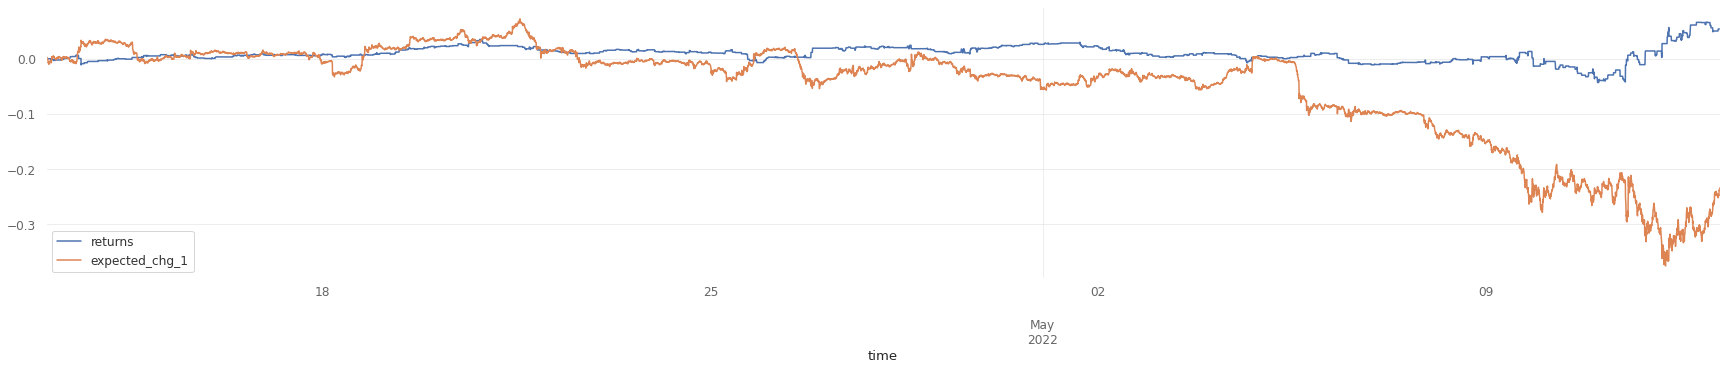

In [7]:
data['signal'] = 0
data['signal'] = np.where(
    (data['corr'] >= -0.05) &
    (data['corr'] <= 0.05),
    np.sign(data['chg']) / -1, data['signal'])
data['returns'] = data['expected_chg_1'] * data['signal']
print(data['signal'].value_counts(True))
data[['returns', 'expected_chg_1']].cumsum().plot(figsize=(30, 5))


<AxesSubplot:>

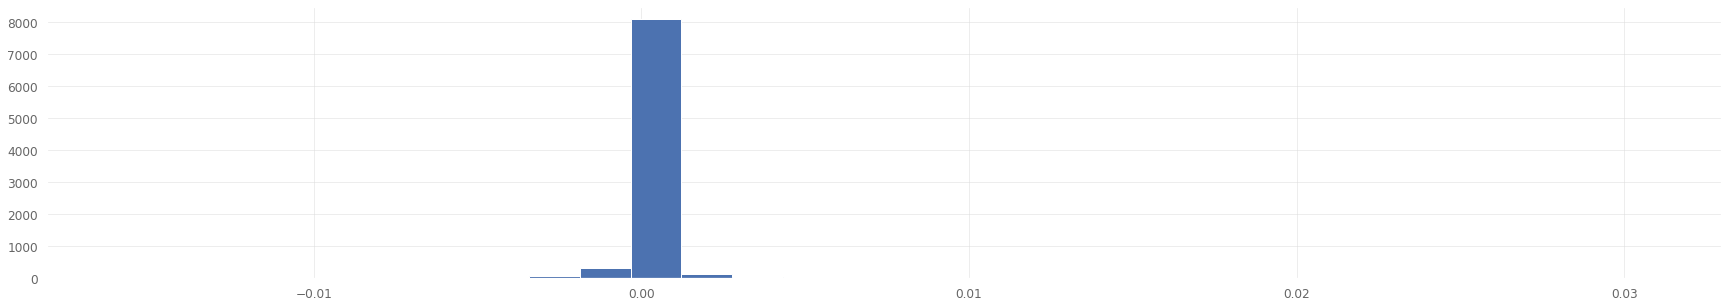

In [8]:
data['returns'].hist(bins=30, figsize=(30, 5))

In [14]:
data['entries'] = np.where(data['signal'] == 1, True, False)
data['exits'] = np.where(data['signal'].shift(1), True, False)
data['short_entries'] = np.where(data['signal'] == -1, True, False)
data['short_exits'] = np.where(data['signal'].shift(1) == -1, True, False)

pf = vbt.Portfolio.from_signals(
    close=data['close'],
    entries=data['entries'],
    exits=data['exits'],
    short_entries=data['short_entries'],
    short_exits=data['short_exits'],
    # fees=0.001,
)

# pf.plot().show()
pf.stats()

Start                               2022-04-13 00:05:00
End                                 2022-05-13 05:25:00
Period                                 30 days 05:25:00
Start Value                                       100.0
End Value                                    107.124532
Total Return [%]                               7.124532
Benchmark Return [%]                         -22.946588
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               5.586868
Max Drawdown Duration                  20 days 19:00:00
Total Trades                                        810
Total Closed Trades                                 810
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  56.296296
Best Trade [%]                                 2.894507
Worst Trade [%]                               -1

In [8]:
def t_statistic(xs, ys):
    r = xs.corr(ys)
    df = xs.count() - 2
    return r * np.sqrt(df / 1 - r ** 2)


def calculate_stat(xs, ys):
    t_value = t_statistic(xs, ys)
    df = xs.count() - 2
    p = 2 * stats.t.sf(t_value, df)
    return {'t-stat': t_value, 'p-value': p}

hypotesis_test = calculate_stat(data['returns'], data['expected_chg_1'])
print(hypotesis_test)

{'t-stat': 4.882326830478422, 'p-value': 1.1531815009030945e-06}


## Test ideas using cuts from pandas

In [9]:
data\
    .groupby(['cuts_corr'])['expected_chg_1']\
    .agg(['mean', 'sum'])

,mean,sum
cuts_corr,,
0.0,-0.007345,-0.066101
1.0,-0.002616,-0.138656
2.0,-0.002033,-0.248027
3.0,-0.001193,-0.249409
4.0,0.001450,0.448020
5.0,-0.000999,-0.314575
6.0,0.000381,0.097610
7.0,-0.000749,-0.116808
8.0,0.000906,0.101490


 1.0    0.522068
-1.0    0.477932
Name: returns, dtype: float64


<AxesSubplot:xlabel='time'>

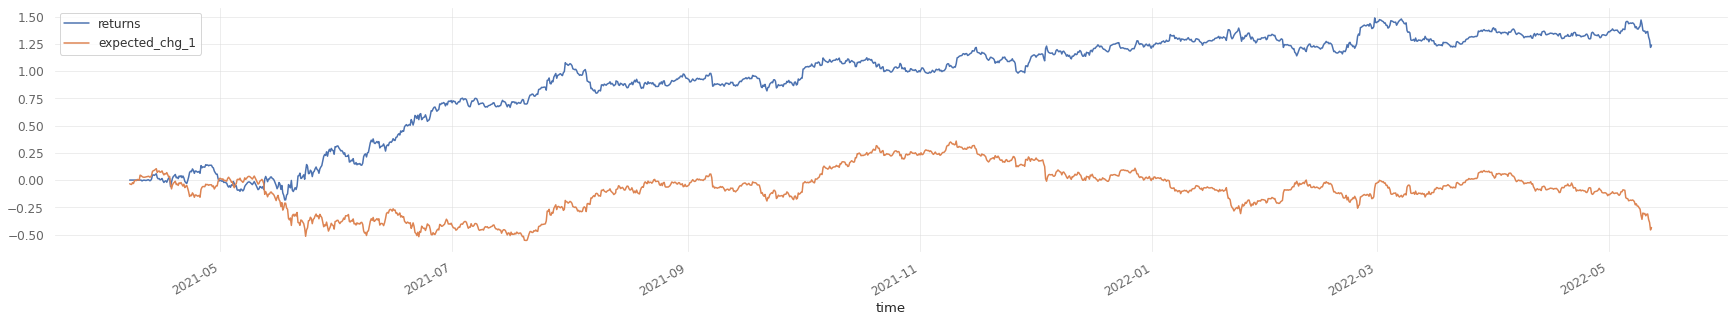

In [10]:
data['signal'] = 0
data['signal'] = np.where(
    data['cuts_corr'].isin([4, 10, 11]),
    1,
    data['signal']
)
data['signal'] = np.where(
    data['cuts_corr'].isin([0, 1, 2, 3, 7, 9]),
    -1,
    data['signal']
)
data['returns'] = data['expected_chg_1'] * data['signal']
print(np.sign(data[data['returns'] != 0]['returns']).value_counts(True))
data[['returns', 'expected_chg_1']].cumsum().plot(figsize=(30, 5))


In [19]:
hypotesis_test = calculate_stat(data['returns'], data['expected_chg_1'])
print(hypotesis_test)

{'t-stat': 5.378885038070349, 'p-value': 8.605308657864835e-08}


In [20]:
data['entries'] = np.where(data['signal'] == 1, True, False)
data['exits'] = np.where(data['signal'].shift(1), True, False)
data['short_entries'] = np.where(data['signal'] == -1, True, False)
data['short_exits'] = np.where(data['signal'].shift(1) == -1, True, False)

pf = vbt.Portfolio.from_signals(
    close=data['close'],
    entries=data['entries'],
    exits=data['exits'],
    short_entries=data['short_entries'],
    short_exits=data['short_exits'],
    fees=0.001,
)

pf.plot().show()

In [21]:
pf.stats()

Start                         2021-04-07 06:00:00
End                           2022-05-12 12:00:00
Period                                       1602
Start Value                                 100.0
End Value                              136.072684
Total Return [%]                        36.072684
Benchmark Return [%]                   -52.428122
Max Gross Exposure [%]                      100.0
Total Fees Paid                         49.073484
Max Drawdown [%]                        33.228468
Max Drawdown Duration                      1177.0
Total Trades                                  193
Total Closed Trades                           193
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            49.222798
Best Trade [%]                          15.805221
Worst Trade [%]                        -11.171422
Avg Winning Trade [%]                    2.885598
Avg Losing Trade [%]                      -2.3459
